Creator: Yen Ting Lin, CCS-3, LANL 

Note: For the manuscript "*Gene expression noise accelerates the evolution of a biological oscillator*", co-authored by Nicolas E. Buchler, NCSU

The code has been reviewed by Richard P. Feynman Center for Innovation at the Los Alamos National Laboratory, with a C number C21109

This notebook simulates the evolutionary processes of a single biophysical parameter $r_0$ for deterministic gene expression dynamics.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from matplotlib import cm 

from multiprocessing import Pool
from subprocess import call, STDOUT

from scipy import signal
from scipy.stats import norm, uniform

In [2]:
plt.rcParams.update({'font.size':14})

In [3]:
par = {'h':3, 'r0':4.0, 'r1':0.0, 'k':0.5, 'gamma':1 }

In [4]:
def Hill(x, par):
    
    return par['r0'] + (par['r1']-par['r0'])* x**par['h']/(par['k']**par['h'] + x**par['h'])

In [5]:
def RHS(t,w,par):
    
    x,y,z=w
    
    dx = Hill(z, par) - par['gamma']*x
    dy = Hill(x, par) - par['gamma']*y
    dz = Hill(y, par) - par['gamma']*z
    
    return np.array([dx,dy,dz])
    

In [6]:
tSpan = np.linspace(0,1000,10001)

In [7]:
populationN = 100
poolN = populationN

In [8]:
def compileParList(par):
    
    populationN = len(par)
    
    parList = np.zeros((populationN, 2))
    
    parList[:,0] = range(populationN)
    parList[:,1] = par[:]
    
    return parList

In [9]:
def batchRun(parList,tSpan):
    
    tN = len(tSpan)
    populationN = len(parList)
    
    output = np.zeros((populationN, tN))
    
    counter = 0
    
    for _,r0Val in parList:
        
        par['r0'] = r0Val
        sol =  solve_ivp(fun=lambda t,z: RHS(t,z,par), t_span=(tSpan[0],tSpan[-1]), y0=(0.1,0.0,0.0), t_eval=tSpan, method='LSODA', rtol=1e-5, atol=1e-5)
        
        output[counter, :]  = sol.y[1,:]
        
        counter += 1

    return output

In [10]:
def evaluatePeak(solutions,dt):
    
    output = []
    
    output_fullPSD = []
    
    populationN = len(solutions)
    
    for i in range(populationN):
    
        data = solutions[i,:]
        x=data[5000:]

        x=(x-np.mean(x))
        fs = 1/dt
        freqTemp, psdTemp = signal.welch(x, fs, nperseg=64, nfft=len(x), window='boxcar', noverlap=0)

        maxDensity = np.amax(psdTemp)
        index = np.where(psdTemp==maxDensity)[0][0]
        maxFrequency = freqTemp[index]
        
        if maxDensity < 1E-4:
            
            maxDensity = 0    
            maxFrequency = 0
            
        output.append([maxFrequency, maxDensity])
        
        output_fullPSD.append(np.vstack((freqTemp, psdTemp)))

    return np.array(output),  np.array(output_fullPSD)

In [11]:
def evaluateFitness(parList,tSpan):
    
    populationN = len(parList)
    
    solutions = batchRun(parList,tSpan)
    
    l,_ = evaluatePeak(solutions, tSpan[1]-tSpan[0])
    
    # combine peak frequency and peak power
    targetF = 0.3

    C0 = 0
    C1 = 1
    
    #return 1.0/(1+(l[:,0]-targetF)**2)
    return l[:,1]/(1+l[:,1])/(1+(l[:,0]-targetF)**2)

# Evolutionary Process

Start with a normal distribution of 100 population.
Every generation, top 10 individual is selected for reproduction, with a small normally-distributed kernel.

In [12]:
def selectionMutation(parList,tSpan,mutationSTD):
    
    populationN = len(parList)
    
    selectionPercentage = 10.
    
    selectedN = np.around(populationN*(selectionPercentage/100)).astype('int64')
    
    # Evaluate the fitness
    f = evaluateFitness(parList,tSpan)

    # Order and select
    selectedIndex = f.argsort()[::-1][:selectedN]

    # select
    selectedPar = parList[selectedIndex,1]
    
    # mutation kernel
    
    newParList = np.zeros((populationN, 2))
    newParList[:,0] = range(populationN)
    
    for i in range(populationN):
        
        # randomly select one parent
        
        parParent = selectedPar[np.random.choice(selectedN)]
        newParList[i,1] = np.clip(np.random.normal(loc = parParent, scale = mutationSTD), 0, np.inf)


    return newParList,f
    
    

In [13]:
# generate N independent paths; for the paper, we have pathN=10
pathN = 1  
tN = 50

summary = np.zeros([2, pathN, tN, populationN])

for pp in range(pathN):

    initialSTD = 0.025
    mutationSTD = 0.025

    initialPar = norm(loc=0.5, scale=initialSTD).rvs(populationN)
    
    parList = compileParList(initialPar)
    
    for tt in range(tN):
    
        print(f'Path {pp}, generation {tt}')
        
        parList,fitness = selectionMutation(parList,tSpan,mutationSTD=mutationSTD)
        
        summary[0, pp, tt, :] = parList[:,1]
        summary[1, pp, tt, :] = fitness[:]
        

Path 0, generation 0
Path 0, generation 1
Path 0, generation 2
Path 0, generation 3
Path 0, generation 4
Path 0, generation 5
Path 0, generation 6
Path 0, generation 7
Path 0, generation 8
Path 0, generation 9
Path 0, generation 10
Path 0, generation 11
Path 0, generation 12
Path 0, generation 13
Path 0, generation 14
Path 0, generation 15
Path 0, generation 16
Path 0, generation 17
Path 0, generation 18
Path 0, generation 19
Path 0, generation 20
Path 0, generation 21
Path 0, generation 22
Path 0, generation 23
Path 0, generation 24
Path 0, generation 25
Path 0, generation 26
Path 0, generation 27
Path 0, generation 28
Path 0, generation 29
Path 0, generation 30
Path 0, generation 31
Path 0, generation 32
Path 0, generation 33
Path 0, generation 34
Path 0, generation 35
Path 0, generation 36
Path 0, generation 37
Path 0, generation 38
Path 0, generation 39
Path 0, generation 40
Path 0, generation 41
Path 0, generation 42
Path 0, generation 43
Path 0, generation 44
Path 0, generation 4

In [14]:
# Save the results
np.savez('repressilator-summary-det-r0', summary=summary)

Text(0, 0.5, '$r_0$')

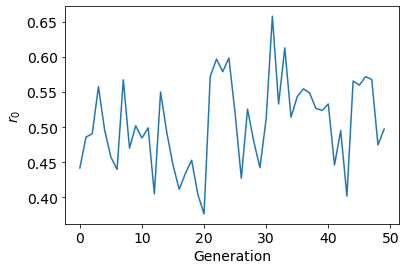

In [15]:
for i in range(pathN):
    
    series = []
    
    for t in range(tN):
        
        fits = summary[1,i,t,:]
        pars = summary[0,i,t,:]
    
        series.append(pars[np.where(fits==np.amax(fits))[0][0]])
        
    plt.plot(range(tN), series)
    
plt.xlabel('Generation')
plt.ylabel('$r_0$')
